In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_geom_DIB import geom_DIB_on_alternatives

In [2]:
# Load data
data = pd.read_csv('../data/optima.dat', sep='\t')

# Remove missing values, i.e. choice = -1
data = data[data['Choice'] != -1]

In [3]:
# display every column of the dataframe
pd.set_option('display.max_columns', None)
data

,ID,DestAct,NbTransf,TimePT,WalkingTimePT,WaitingTimePT,CostPT,CostCar,TimeCar,NbHousehold,NbChild,NbCar,NbMoto,NbBicy,NbBicyChild,NbComp,NbTV,Internet,NewsPaperSubs,NbCellPhones,NbSmartPhone,HouseType,OwnHouse,NbRoomsHouse,YearsInHouse,Income,Gender,BirthYear,Mothertongue,FamilSitu,OccupStat,SocioProfCat,CalculatedIncome,Education,HalfFareST,LineRelST,GenAbST,AreaRelST,OtherST,CarAvail,MarginalCostPT,CostCarCHF,Envir01,Envir02,Envir03,Envir04,Envir05,Envir06,Mobil01,Mobil02,Mobil03,Mobil04,Mobil05,Mobil06,Mobil07,Mobil08,Mobil09,Mobil10,Mobil11,Mobil12,Mobil13,Mobil14,Mobil15,Mobil16,Mobil17,Mobil18,Mobil19,Mobil20,Mobil21,Mobil22,Mobil23,Mobil24,Mobil25,Mobil26,Mobil27,ResidCh01,ResidCh02,ResidCh03,ResidCh04,ResidCh05,ResidCh06,ResidCh07,LifSty01,LifSty02,LifSty03,LifSty04,LifSty05,LifSty06,LifSty07,LifSty08,LifSty09,LifSty10,LifSty11,LifSty12,LifSty13,LifSty14,TripPurpose,TypeCommune,UrbRur,LangCode,ClassifCodeLine,frequency,ResidChild,NbTrajects,FreqCarPar,FreqTrainPar,FreqOtherPar,FreqTripHouseh,Region,distance_km,Choice,InVehicleTime,ModeToSchool,ReportedDuration,CoderegionCAR,age,Weight
0,10350017,2,4,85,23,10,12.4,3.17,32,2,0,1,0,3,0,2,1,1,2,2,2,1,2,5.0,1,4,1,1983,2,2,3,3,7000,7,2,2,1,2,2,2,0.0,4.54,3,5,1,3,5,5,5,3,4,5,3,1,1,1,5,6,5,1,5,1,5,1,5,5,5,1,5,1,5,5,5,5,5,3,5,1,1,1,1,5,4,3,5,5,6,5,1,5,1,2,3,5,5,1,1,7,1,1,4,1,5,2,4,1,1,4,1,30.0,1,52,3,255,1,27,0.000379
2,10350025,11,2,82,33,5,3.0,0.45,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,2,2,-1,3.0,0.64,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,3,7,1,1,4,1,-1,1,-1,-1,-1,2,1,4.5,0,44,-1,20,1,-1,0.000368
3,10350075,1,3,107,21,31,24.0,2.36,23,2,0,1,0,0,0,1,2,1,1,2,0,1,1,5.0,29,2,2,1947,2,2,2,4,3250,3,2,2,2,2,2,1,24.0,3.38,3,2,3,4,4,4,4,4,3,5,3,4,4,3,5,2,4,2,5,5,4,3,4,5,4,1,4,4,4,2,4,2,4,4,4,4,3,3,4,5,4,2,4,4,3,3,3,4,3,2,4,4,4,2,1,7,1,1,4,1,5,1,3,2,2,1,1,25.0,1,55,-1,30,1,63,0.000368
4,10350085,1,5,190,116,18,10.8,1.16,14,3,0,2,0,3,0,1,2,1,2,2,0,1,1,4.0,22,4,1,1953,2,3,1,6,7000,3,2,2,2,2,2,1,10.8,1.66,1,3,3,3,5,4,5,1,3,4,4,5,5,1,2,4,5,1,5,5,3,5,4,6,6,6,5,1,5,3,1,6,1,3,3,2,2,1,3,3,3,4,3,3,1,3,1,1,3,3,3,3,4,1,1,7,1,1,4,1,6,2,2,1,2,3,1,12.5,1,56,-1,20,1,57,0.000409
5,10350086,1,4,116,38,29,9.6,1.89,20,3,0,2,0,3,0,1,2,1,2,3,0,1,1,4.0,22,4,2,1952,2,3,4,6,7000,3,2,2,2,2,2,2,9.6,2.71,2,4,3,2,5,4,4,2,3,4,3,5,2,1,3,3,5,2,5,4,3,5,3,3,3,2,4,1,2,2,2,2,2,3,3,4,2,1,2,5,4,4,4,3,1,2,2,4,3,4,2,2,1,2,1,7,1,1,4,1,5,2,1,2,2,3,1,19.0,1,49,-1,30,1,58,0.000368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,96040531,1,4,148,28,69,10.4,3.92,40,5,2,1,1,4,2,1,1,1,1,2,0,1,2,7.0,16,2,2,1973,1,3,2,8,3250,3,2,2,2,2,2,1,10.4,5.62,3,4,4,3,3,3,3,3,3,3,3,5,5,3,4,4,4,4,5,5,3,3,3,3,3,3,4,4,4,4,3,3,3,4,3,3,3,3,3,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,8,1,2,3,2,5,1,1,1,1,3,7,42.0,1,51,5,35,7,37,0.000870
2261,96040537,8,0,139,116,0,14.4,3.18,43,5,0,2,1,1,0,2,1,1,2,5,0,1,1,7.0,23,4,2,1964,1,3,1,3,7000,3,2,2,2,2,2,1,14.4,4.56,2,3,4,6,6,4,4,6,4,6,6,5,5,2,6,6,5,2,5,6,6,4,4,3,3,3,6,2,4,6,2,6,6,1,1,2,3,1,1,5,2,2,4,5,5,2,1,5,3,1,2,4,2,4,-1,8,1,2,3,2,6,4,4,1,1,3,7,32.0,1,23,5,70,7,46,0.000368
2262,96040537,8,0,71,57,0,6.0,0.94,12,5,0,2,1,1,0,2,1,1,2,5,0,1,1,7.0,23,4,2,1964,1,3,1,3,7000,3,2,2,2,2,2,1,6.0,1.35,2,3,4,6,6,4,4,6,4,6,6,5,5,2,6,6,5,2,5,6,6,4,4,3,3,3,6,2,4,6,2,6,6,1,1,2,3,1,1,5,2,2,4,5,5,2,1,5,3,1,2,4,2,4,3,8,1,2,3,2,6,2,4,1,1,3,7,9.0,1,14,5,20,7,46,0.000368
2263,96040538,11,2,118,70,10,11.4,1.77,24,5,0,2,1,1,0,2,1,1,2,5,0,1,1

In [4]:
data_used = data[['ID', 'TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF', 'ReportedDuration', 'Choice']]

In [5]:
data_used

,ID,TimePT,MarginalCostPT,TimeCar,CostCarCHF,ReportedDuration,Choice
0,10350017,85,0.0,32,4.54,255,1
2,10350025,82,3.0,6,0.64,20,0
3,10350075,107,24.0,23,3.38,30,1
4,10350085,190,10.8,14,1.66,20,1
5,10350086,116,9.6,20,2.71,30,1
...,...,...,...,...,...,...,...
2259,96040531,148,10.4,40,5.62,35,1
2261,96040537,139,14.4,43,4.56,70,1
2262,96040537,71,6.0,12,1.35,20,1
2263,96040538,118,11.4,24,2.54,30,1


In [15]:
# beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_private_PT",
#                "lambda_PT_soft", "base_alpha_PT_WITH_private"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_optima_CNLM(beta, data):
    alpha_PT_WITH_private = np.exp(beta[6]) / (1 + np.exp(beta[6]))
    alpha_PT_WITH_soft = 1 - alpha_PT_WITH_private

    # define utility functions
    data['U_PT'] = beta[2] * data['TimePT'] + beta[3] * data['MarginalCostPT']
    data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
    data['U_soft'] = beta[1] + beta[2] * data['ReportedDuration']

    # combined utility terms inside nests
    data['U_private_PT'] = (alpha_PT_WITH_private * np.exp(data['U_PT'])) ** (1 / beta[4]) + \
                          (1 * np.exp(data['U_private'])) ** (1 / beta[4])
    data['U_PT_soft'] = (alpha_PT_WITH_soft * np.exp(data['U_PT'])) ** (1 / beta[5]) + \
                         (1 * np.exp(data['U_soft'])) ** (1 / beta[5])

    # Nest probabilities
    data['P_nest_private_PT'] = data['U_private_PT'] ** beta[4] / \
                                (data['U_private_PT'] ** beta[4] + data['U_PT_soft'] ** beta[5])
    data['P_nest_PT_soft'] = 1 - data['P_nest_private_PT']

    # Within nest probabilities for any nests with > 1 alt
    data['P_PT_in_private_PT'] = (alpha_PT_WITH_private * np.exp(data['U_PT'])) ** (1 / beta[4]) / \
                                    data['U_private_PT'] 
    data['P_private_in_private_PT'] = 1 - data['P_PT_in_private_PT']
    data['P_PT_in_PT_soft'] = (alpha_PT_WITH_soft * np.exp(data['U_PT'])) ** (1 / beta[5]) / \
                                data['U_PT_soft']
    data['P_soft_in_PT_soft'] = 1 - data['P_PT_in_PT_soft']

    # Full probabilities
    data['P_PT_1'] = data['P_nest_private_PT'] * data['P_PT_in_private_PT'] + \
                        data['P_nest_PT_soft'] * data['P_PT_in_PT_soft']
    data['P_private_2'] = data['P_nest_private_PT'] * data['P_private_in_private_PT']
    data['P_soft_3'] = data['P_nest_PT_soft'] * data['P_soft_in_PT_soft']

    # calculate probability for chosen alternative for each row in the data table
    data['P'] = ((data['Choice'] == 0) * data['P_PT_1'] +
                 (data['Choice'] == 1) * data['P_private_2'] +
                 (data['Choice'] == 2) * data['P_soft_3'])

    # take product across choices for the same person (likelihood)
    # then take the log for log-likelihood
    LL = data.groupby('ID')['P'].prod().apply(np.log).sum()

    return -LL  # We minimize negative log-likelihood

In [16]:
# Define model parameters
beta = np.array([0, 0, 0, 0, 1, 1, 0])
beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_private_PT",
              "lambda_PT_soft", "base_alpha_PT_WITH_private"]
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data_used, beta, beta_names, log_likelihood_optima_CNLM)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3974/1760568815.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_PT'] = beta[2] * data['TimePT'] + beta[3] * data['MarginalCostPT']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3974/1760568815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3974/1760568815.py:12: SettingWithC

Optimization Results:
                    Parameter   Estimate  Robust Asymptotic SE  t-statistic  \
0                 ASC_private   1.000162              0.769460     1.299824   
1                    ASC_soft  -0.982628              0.875038    -1.122955   
2                   BETA_Time  -0.009529              0.002116    -4.503897   
3                   BETA_Cost  -0.012216              0.006452    -1.893482   
4           lambda_private_PT   1.557634              0.654015     2.381650   
5              lambda_PT_soft  -0.012701              0.338538    -0.037518   
6  base_alpha_PT_WITH_private  10.911495              1.268427     8.602382   

    p-value  
0  0.193819  
1  0.261598  
2  0.000007  
3  0.058446  
4  0.017333  
5  0.970076  
6  0.000000  
AIC: 14.0
BIC: 52.86933458949903
Log-likelihood: 0.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3974/1760568815.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_PT'] = beta[2] * data['TimePT'] + beta[3] * data['MarginalCostPT']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3974/1760568815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [14]:
data_used

,ID,TimePT,MarginalCostPT,TimeCar,CostCarCHF,ReportedDuration,Choice,U_PT,U_private,U_soft,U_private_PT,U_PT_soft,P_nest_private_PT,P_nest_PT_soft,P_PT_in_private_PT,P_private_in_private_PT,P_PT_in_PT_soft,P_soft_in_PT_soft,P_PT_1,P_private_2,P_soft_3,P
0,10350017,85,0.0,32,4.54,255,1,-0.809987,0.639765,-3.412590,2.102423,inf,1.0,0.0,0.282772,0.717228,NaN,NaN,NaN,0.717228,NaN,NaN
2,10350025,82,3.0,6,0.64,20,0,-0.818048,0.935168,-1.173214,2.414245,inf,1.0,0.0,0.244979,0.755021,NaN,NaN,NaN,0.755021,NaN,NaN
3,10350075,107,24.0,23,3.38,30,1,-1.312818,0.739699,-1.268506,2.038317,inf,1.0,0.0,0.211197,0.788803,NaN,NaN,NaN,0.788803,NaN,NaN
4,10350085,190,10.8,14,1.66,20,1,-1.942494,0.846474,-1.173214,2.009252,inf,1.0,0.0,0.143008,0.856992,NaN,NaN,NaN,0.856992,NaN,NaN
5,10350086,116,9.6,20,2.71,30,1,-1.222669,0.776471,-1.268506,2.102376,inf,1.0,0.0,0.216962,0.783038,NaN,NaN,NaN,0.783038,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,96040531,148,10.4,40,5.62,35,1,-1.537378,0.550337,-1.316153,1.796471,inf,1.0,0.0,0.207457,0.792543,NaN,NaN,NaN,0.792543,NaN,NaN
2261,96040537,139,14.4,43,4.56,70,1,-1.500479,0.534699,-1.649677,1.791182,inf,1.0,0.0,0.213057,0.786943,NaN,NaN,NaN,0.786943,NaN,NaN
2262,96040537,71,6.0,12,1.35,20,1,-0.749874,0.869319,-1.173214,2.365252,inf,1.0,0.0,0.261240,0.738760,NaN,NaN,NaN,0.738760,NaN,NaN
2263,96040538,118,11.4,24,2.54,30,1,-1.263717,0.740431,-1.268506,2.052860,inf,1.0,0.0,0.216416,0.783584,NaN,NaN,NaN,0.783584,NaN,NaN


In [8]:
df_input = data[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF', 'ReportedDuration']]
# Calculate frequencies and probabilities
vector_counts = df_input.value_counts().reset_index(name='Frequency')
vector_counts['Probability'] = vector_counts['Frequency'] / len(df_input)

# Creating a tuple of attributes to facilitate mapping
vector_counts['tuple'] = vector_counts[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF',
                                         'ReportedDuration']].apply(tuple, axis=1)
probability_map = vector_counts.set_index('tuple')['Probability'].to_dict()

# Assign the probability to each row based on its tuple of attributes
df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3309/1679802737.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


In [9]:
# Computation of p(x,y)
p_x = df_input['Probability'].values

p_y_given_x = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [10]:
def simulate_choice_optima(row):
    """
    Function to simulate a choice based on cumulative probabilities.

    Parameters:
    - row: pandas Series or DataFrame row containing probabilities for each choice

    Returns:
    - The simulated choice (an integer between 1 and the number of choices)
    """
    # Generate a random number between 0 and 1
    random_number = np.random.rand()
    
    # Calculate cumulative probabilities
    probabilities = row[['P_PT_1', 'P_private_2', 'P_soft_3']]
    cumulative_probs = probabilities.cumsum()
    
    # Determine simulated choice based on random number
    for i, cumulative_prob in enumerate(cumulative_probs):
        if random_number <= cumulative_prob:
            return i+1

In [11]:
np.random.seed(123)
data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)
data_used

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3309/2856924636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)


,ID,TimePT,MarginalCostPT,TimeCar,CostCarCHF,ReportedDuration,Choice,U_PT,U_private,U_soft,logsum_PT_soft,P_nest_PT_soft,P_nest_private,P_PT_in_PT_soft,P_soft_in_PT_soft,P_PT_1,P_private_2,P_soft_3,P,simulated_choice
0,10350017,85,0.0,32,4.54,255,1,-0.461307,0.574138,-12.075196,0.081825,0.488593,0.511407,0.857919,0.142081,0.419173,0.511407,0.069420,0.511407,2
2,10350025,82,3.0,6,0.64,20,0,-0.799112,1.175556,-10.799819,0.069044,0.325281,0.674719,0.824675,0.175325,0.268252,0.674719,0.057030,0.268252,2
3,10350075,107,24.0,23,3.38,30,1,-3.413398,0.759896,-10.854090,-0.253875,0.083198,0.916802,0.759876,0.240124,0.063220,0.916802,0.019978,0.916802,2
4,10350085,190,10.8,14,1.66,20,1,-2.305869,1.011750,-10.799819,-0.119203,0.144096,0.855904,0.788360,0.211640,0.113600,0.855904,0.030497,0.855904,2
5,10350086,116,9.6,20,2.71,30,1,-1.762626,0.855257,-10.854090,-0.053974,0.230788,0.769212,0.803383,0.196617,0.185411,0.769212,0.045377,0.769212,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,96040531,148,10.4,40,5.62,35,1,-2.030718,0.403250,-10.881226,-0.088035,0.274509,0.725491,0.797424,0.202576,0.218900,0.725491,0.055609,0.725491,2
2261,96040537,139,14.4,43,4.56,70,1,-2.453989,0.512079,-11.071176,-0.146143,0.189078,0.810922,0.791526,0.208474,0.149660,0.810922,0.039418,0.810922,2
2262,96040537,71,6.0,12,1.35,20,1,-1.093501,1.059193,-10.799819,0.031608,0.298377,0.701623,0.817987,0.182013,0.244069,0.701623,0.054308,0.701623,2
2263,96040538,118,11.4,24,2.54,30,1,-1.985932,0.853613,-10.854090,-0.081654,0.200847,0.799153,0.797865,0.202135,0.160248,0.799153,0.040598,0.799153,2


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

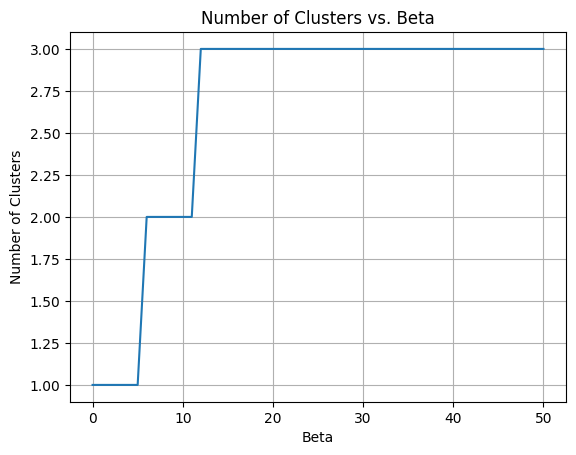

In [12]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [13]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=30, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000


In [14]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [15]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data_used['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_used.groupby(['cluster', 'Choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = data_used.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data_used.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
0    1503
2     316
1      87
Name: count, dtype: int64

 Choice     0    1    2
cluster               
0        430  961  112
1         70   16    1
2         36  279    1

 max_proba   1     2
cluster            
0          50  1453
1          87     0
2           0   316

 simulated_choice    1    2    3
cluster                        
0                 451  942  110
1                  54   11   22
2                  27  285    4


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3309/2352194042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3309/2352194042.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
